# Real Estate Data Pipeline

Author - Ghazal E Ashar

A 20-step project simulating real-world ETL workflows: ingestion, cleaning, transformation, partitioning, correlation checks, and visualization for real estate dataset.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

## 1. Basic Ingestion & Schema Handling

### 1.1 Load Dataset & Schema Inspection.
**Purpose:** Simulate initial data ingestion with comprehensive profiling  
**Concepts:** Data Ingestion, Schema Validation, Data Profiling

In [6]:
df = pd.read_csv("realtor-data.csv")

In [7]:
# Add synthetic listing_date (between 2018-01-01 and 2023-12-31)
# Define start & end date range
start = datetime(2018, 1, 1)
end = datetime(2023, 12, 31)

# Generate random timestamps
df['listing_date'] = pd.to_datetime(
    np.random.randint(
        int(start.timestamp()), 
        int(end.timestamp()), 
        df.shape[0]
    ), 
    unit='s'
)

In [8]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,listing_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,2022-11-04 01:48:54
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,2021-09-20 16:18:26
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,2021-11-19 15:29:52
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,2020-03-27 08:21:39
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,2021-04-25 15:17:26


In [9]:
print(df.columns)

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'listing_date'],
      dtype='object')


In [10]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   brokered_by   1047537 non-null  float64       
 1   status        1048575 non-null  object        
 2   price         1047485 non-null  float64       
 3   bed           738569 non-null   float64       
 4   bath          723607 non-null   float64       
 5   acre_lot      870247 non-null   float64       
 6   street        1041799 non-null  float64       
 7   city          1047715 non-null  object        
 8   state         1048568 non-null  object        
 9   zip_code      1048416 non-null  float64       
 10  house_size    683689 non-null   float64       
 11  listing_date  1048575 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 96.0+ MB
None


In [11]:
print(df.isnull().sum())

brokered_by       1038
status               0
price             1090
bed             310006
bath            324968
acre_lot        178328
street            6776
city               860
state                7
zip_code           159
house_size      364886
listing_date         0
dtype: int64


**Expected Output:** Comprehensive dataset overview with schema details  
**Data Engineering Insight:** Early schema validation prevents downstream pipeline failures

### 1.2 Check row count (validate ingestion completeness).
**Purpose:** Check count of rows  
**Concepts:** Data Quality, Ingestion Monitoring

In [14]:
print("Row count:", len(df))

Row count: 1048575


**Expected Output:** Length of records  
**Data Engineering Insight:** Early validation catches data quality issues before they propagate

### 1.3 Column Renaming to snake_case
**Purpose:** Standardize column names for pipeline consistency  
**Concepts:** Data Standardization, Naming Conventions

In [17]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(f"\nStandardized columns: {list(df.columns)}")


Standardized columns: ['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state', 'zip_code', 'house_size', 'listing_date']


**Expected Output:** All columns converted to snake_case format  
**Data Engineering Insight:** Consistent naming prevents field reference errors

### 1.4 Enforce schema: convert listing_date → datetime.
**Purpose:** Enrich dataset and enforce proper data types  
**Concepts:** Data Enrichment, Schema Enforcement

In [20]:
# Convert listing_date to proper datetime
df['listing_date'] = pd.to_datetime(df['listing_date'])
print(f"{df['listing_date'].dtype}")

datetime64[ns]


**Expected Output:** New synthetic field added with proper data types   
**Data Engineering Insight:** Synthetic data enrichment enables more comprehensive analysis

### 1.5 Data Quality Logging
**Purpose:** Log missing values for quality monitoring  
**Concepts:** Data Quality Assessment, Pipeline Observability

In [23]:
# Comprehensive missing value analysis

missing_summary = []
for column in df.columns:
    missing_count = df[column].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    
    missing_summary.append({
        'column': column,
        'missing_count': missing_count,
        'missing_percentage': round(missing_pct, 2),
        'data_type': str(df[column].dtype)
    })

quality_df = pd.DataFrame(missing_summary)
quality_df = quality_df.sort_values('missing_percentage', ascending=False)

print("Missing Value Report:")
print(quality_df.to_string(index=False))

Missing Value Report:
      column  missing_count  missing_percentage      data_type
  house_size         364886               34.80        float64
        bath         324968               30.99        float64
         bed         310006               29.56        float64
    acre_lot         178328               17.01        float64
      street           6776                0.65        float64
 brokered_by           1038                0.10        float64
       price           1090                0.10        float64
        city            860                0.08         object
    zip_code            159                0.02        float64
      status              0                0.00         object
       state              7                0.00         object
listing_date              0                0.00 datetime64[ns]


**Expected Output:** Detailed missing value analysis sorted by severity  
**Data Engineering Insight:** Quality logging enables data-driven cleaning decisions

## 2. Intermediate Cleaning & Transformation

### 2.1 Fill Missing Values (Mean, Median, Mode)  
**Purpose:** Apply systematic missing value imputation strategies  
**Concepts:** Data Imputation, Statistical Methods

In [27]:
# Numeric fields - use median for price-related
numeric_fields = ['price', 'house_size', 'acre_lot', 'size_sqft']
for field in numeric_fields:
    if field in df.columns:
        missing_before = df[field].isnull().sum()
        if missing_before > 0:
            median_val = df[field].median()
            df[field].fillna(median_val, inplace=True)
            print(f"{field}: Filled {missing_before:,} nulls with median ({median_val:,.0f})")

# Categorical fields - use mode
categorical_fields = ['city', 'state', ]
for field in categorical_fields:
    if field in df.columns:
        missing_before = df[field].isnull().sum()
        if missing_before > 0:
            mode_val = df[field].mode().iloc[0]
            df[field].fillna(mode_val, inplace=True)
            print(f"{field}: Filled {missing_before:,} nulls with mode ('{mode_val}')")

# Bed/bath - use mean rounded to nearest integer
for field in ['bed', 'bath']:
    if field in df.columns:
        missing_before = df[field].isnull().sum()
        if missing_before > 0:
            mean_val = df[field].mean()
            df[field].fillna(mean_val, inplace=True)
            print(f"{field}: Filled {missing_before:,} nulls with mean ({mean_val:.1f})")
            
print(f"Rows: {len(df):,}")
print(f"\nTotal remaining nulls: {df.isnull().sum().sum()}")

price: Filled 1,090 nulls with median (276,000)
house_size: Filled 364,886 nulls with median (1,800)
acre_lot: Filled 178,328 nulls with median (0)
city: Filled 860 nulls with mode ('Chicago')
state: Filled 7 nulls with mode ('Florida')
bed: Filled 310,006 nulls with mean (3.3)
bath: Filled 324,968 nulls with mean (2.5)
Rows: 1,048,575

Total remaining nulls: 7973


In [28]:
df = df.drop(['street', 'brokered_by', 'zip_code'], axis=1)

print(f"Rows: {len(df):,}")
print(f"Total remaining nulls: {df.isnull().sum().sum()}")

Rows: 1,048,575
Total remaining nulls: 0


**Expected Output:** All missing values filled using appropriate statistical methods  
**Data Engineering Insight:** Strategic imputation preserves data distribution patterns

### 2.2 Remove Duplicates (Deduplication)
**Purpose:** Ensure data uniqueness for pipeline integrity  
**Concepts:** Data Deduplication, Quality Control

In [31]:
# Check exact duplicates
initial_count = len(df)
exact_dupes = df.duplicated().sum()
print(f"Exact duplicates found: {exact_dupes:,}")

# Remove exact duplicates
df_clean = df.drop_duplicates()
after_exact = len(df_clean)

final_count = len(df_clean)
total_removed = initial_count - final_count

print(f"\nDeduplication Summary:")
print(f"-Initial: {initial_count:,} records")
print(f"-Final: {final_count:,} records")
print(f"-Removed: {total_removed:,} ({total_removed/initial_count*100:.1f}%)")

df = df_clean

Exact duplicates found: 0

Deduplication Summary:
-Initial: 1,048,575 records
-Final: 1,048,575 records
-Removed: 0 (0.0%)


**Expected Output:** Dataset with duplicates removed  
**Data Engineering Insight:** Deduplication ensures data quality

### 2.3 Group Data - Average Price by City
**Purpose:** Generate business aggregations for market analysis  
**Concepts:** Data Aggregation, Market Intelligence

In [34]:
avg_price_city = df.groupby('city')['price'].mean().reset_index()
print(avg_price_city)

                                  city         price
0      100 89 Lower Shepard Creek Road  1.900000e+06
1                  139th Ave Unit Peck  2.000000e+04
2                    177th Ave Wabasha  9.600000e+04
3                    178th Ave Wabasha  8.250000e+04
4                    21 27 Tommie Lane  3.300000e+05
...                                ...           ...
15968                          Zortman  2.250000e+05
15969                     Zumbro Falls  2.420375e+05
15970                         Zumbrota  3.024520e+05
15971                             Zuni  4.449500e+05
15972                           Zwolle  1.925999e+05

[15973 rows x 2 columns]


**Expected Output:** City-level market metrics with pricing analysis  
**Data Engineering Insight:** Aggregations transform raw data into business intelligence

### 2.4 Derive KPI - Price per Square Foot
**Purpose:** Create calculated business metrics  
**Concepts:** KPI Generation, Derived Metrics

In [37]:
df['price_per_sqft'] = (df['price'] / df['house_size']).round(2)
df.head()

,status,price,bed,bath,acre_lot,city,state,house_size,listing_date,price_per_sqft
0,for_sale,105000.0,3.0,2.0,0.12,Adjuntas,Puerto Rico,920.0,2022-11-04 01:48:54,114.13
1,for_sale,80000.0,4.0,2.0,0.08,Adjuntas,Puerto Rico,1527.0,2021-09-20 16:18:26,52.39
2,for_sale,67000.0,2.0,1.0,0.15,Juana Diaz,Puerto Rico,748.0,2021-11-19 15:29:52,89.57
3,for_sale,145000.0,4.0,2.0,0.10,Ponce,Puerto Rico,1800.0,2020-03-27 08:21:39,80.56
4,for_sale,65000.0,6.0,2.0,0.05,Mayaguez,Puerto Rico,1800.0,2021-04-25 15:17:26,36.11


**Expected Output:** New KPI fields with business value calculations  
**Data Engineering Insight:** Derived metrics enable advanced analytics and reporting

### 2.5 Partition Dataset by Year/Month
**Purpose:** Implement data partitioning for efficient storage/processing  
**Concepts:** Data Partitioning, Performance Optimization

In [40]:
# Extract time components
df['listing_year'] = df['listing_date'].dt.year
df['listing_month'] = df['listing_date'].dt.month

# Show partition distribution
print("Partition Distribution:")
print("By Year:")
year_dist = df['listing_year'].value_counts().sort_index()
print(year_dist.to_string())

# Show partition distribution
print("\nPartition Distribution:")
print("By Month:")
month_dist = df['listing_month'].value_counts().sort_index()
print(month_dist.to_string())

# Get latest year from dataset
latest_year = df['listing_year'].max()

# Create monthly partition for latest year
latest_year_data = df[df['listing_year'] == latest_year]

monthly_partitions = latest_year_data.groupby('listing_month').size()

print(f"\nMonthly partitions for {latest_year}:")
for month, count in monthly_partitions.items():
    print(f"  Month {month:02d}: {count:,} records")

Partition Distribution:
By Year:
listing_year
2017       114
2018    174593
2019    174826
2020    175118
2021    175349
2022    174054
2023    174521

Partition Distribution:
By Month:
listing_month
1     88858
2     81053
3     89159
4     86194
5     89128
6     86542
7     88708
8     89468
9     86796
10    88970
11    85684
12    88015

Monthly partitions for 2023:
  Month 01: 14,851 records
  Month 02: 13,548 records
  Month 03: 14,926 records
  Month 04: 14,302 records
  Month 05: 14,863 records
  Month 06: 14,543 records
  Month 07: 14,892 records
  Month 08: 14,919 records
  Month 09: 14,448 records
  Month 10: 14,780 records
  Month 11: 14,162 records
  Month 12: 14,287 records


In [41]:
print("By Year Partitions created:")
for year in df['listing_year'].unique():
    year_data = df[df['listing_year'] == year]
    print(f"  {year}: {len(year_data):,} records")

print("\nBy Month Partitions created:")
for month in df['listing_month'].unique():
    month_data = df[df['listing_month'] == month]
    print(f"  {month}: {len(month_data):,} records")

By Year Partitions created:
  2022: 174,054 records
  2021: 175,349 records
  2020: 175,118 records
  2023: 174,521 records
  2018: 174,593 records
  2019: 174,826 records
  2017: 114 records

By Month Partitions created:
  11: 85,684 records
  9: 86,796 records
  3: 89,159 records
  4: 86,194 records
  8: 89,468 records
  5: 89,128 records
  1: 88,858 records
  10: 88,970 records
  6: 86,542 records
  12: 88,015 records
  2: 81,053 records
  7: 88,708 records


**Expected Output:** Time-based partitions with distribution analysis  
**Data Engineering Insight:** Partitioning improves query performance and enables parallel processing

## 3. Advanced ETL Logic

### 3.1 Top 5 Properties by City
**Purpose:** Identify top performers for business intelligence  
**Concepts:** Ranking, Business Intelligence, Top-N Analysis

In [45]:
top_5_cities = df['city'].value_counts().head(5)

print(top_5_cities)

city
Chicago          13548
New York City     8248
Philadelphia      8206
Miami             6128
Jacksonville      5873
Name: count, dtype: int64


**Expected Output:** Rankings of properties by city  
**Data Engineering Insight:** Top-N analysis helps identify outliers and premium segments

### 3.2: Pivot Table - Average Prices by City vs Year
**Purpose:** Create multi-dimensional business views  
**Concepts:** Pivot Tables, Multi-dimensional Analysis

In [48]:
pivot = df.pivot_table(values='price', index='city', columns='listing_year', aggfunc='mean', fill_value=0)
pivot = pivot.round(0).astype(int)
print(pivot.tail(5))

listing_year  2017    2018    2019    2020    2021    2022    2023
city                                                              
Zortman          0  225000       0       0       0       0       0
Zumbro Falls     0       0  236633  379900  257500       0  196333
Zumbrota         0  312450  358550  209620  202967  342400  327425
Zuni             0       0       0  630000  259900       0       0
Zwolle           0  176488  339950  172000  158566  198285  125446


**Expected Output:** Multi-dimensional pivot analysis showing market trends  
**Data Engineering Insight:** Pivot tables reveal patterns across multiple dimensions

### 3.3 Correlation Matrix
**Purpose:** Validate data relationships for quality assurance  
**Concepts:** Statistical Validation, Data Relationships

In [51]:
corr = df[['price', 'house_size', 'bed', 'bath']].corr()
corr

,price,house_size,bed,bath
price,1.000000,0.018413,0.077056,0.130626
house_size,0.018413,1.000000,0.057896,0.064342
bed,0.077056,0.057896,1.000000,0.540435
bath,0.130626,0.064342,0.540435,1.000000


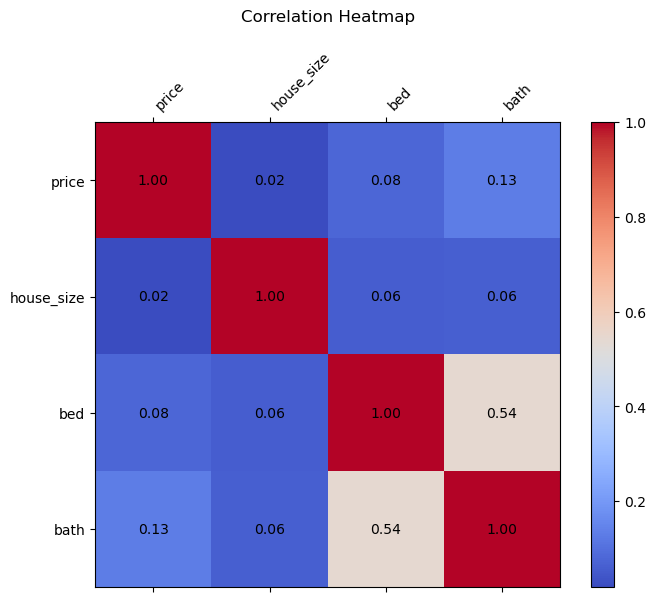

In [52]:
plt.figure(figsize=(8,6))
cax = plt.matshow(corr, cmap='coolwarm', fignum=1)
plt.colorbar(cax)

# Add ticks
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='left')
plt.yticks(range(len(corr.columns)), corr.columns)

# Add annotations
for (i, j), val in np.ndenumerate(corr.values):
    plt.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

plt.title("Correlation Heatmap", pad=20)
plt.show()

**Expected Output:** Correlation matrix with relationship validation  
**Data Engineering Insight:** Correlation analysis validates expected relationships and identifies data quality issues

### 3.4 Export to Multiple Formats (CSV + Parquet)
**Purpose:** Implement the "Load" step of ETL pipeline  
**Concepts:** Data Export, Format Optimization, ETL Load Phase

In [55]:
df.to_csv("cleaned_real_estate.csv", index=False)
df.to_parquet("cleaned_real_estate.parquet", index=False)

**Expected Output:** Multiple export formats with size optimization  
**Data Engineering Insight:** Format selection impacts storage efficiency and query performance

### 3.5 Create reusable ETL function to load → clean → transform.
**Purpose:** Build production-ready, reusable pipeline code  
**Concepts:** Code Reusability, Production ETL, Function Design

In [58]:
def etl(filepath, output_prefix = "cleaned_real_estate"):
    # Load
    df = pd.read_csv(filepath)
    
    # Standardize column names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    # Numeric fields - median
    numeric_fields = ['price', 'house_size', 'acre_lot']
    for field in numeric_fields:
        if field in df.columns:
            median_val = df[field].median()
            df[field].fillna(median_val, inplace=True)
    
    # Categorical fields - mode
    categorical_fields = ['city', 'state', 'status']
    for field in categorical_fields:
        if field in df.columns:
            mode_val = df[field].mode().iloc[0]
            df[field].fillna(mode_val, inplace=True)
    
    # Bed/bath - mean
    for field in ['bed', 'bath']:
        if field in df.columns:
            mean_val = df[field].mean()
            df[field].fillna(mean_val, inplace=True)
    
    # Deduplicate
    df = df.drop_duplicates()
    
    # Derived feature
    if 'price' in df.columns and 'house_size' in df.columns:
        df['price_per_sqft'] = (df['price'] / df['house_size']).round(2)
    
    # Export
    csv_path = f"{output_prefix}.csv"
    parquet_path = f"{output_prefix}.parquet"
    df.to_csv(csv_path, index=False)
    df.to_parquet(parquet_path, index=False)
    
    print(f"ETL Complete \nRows: {len(df):,}")
    print(f"Saved to:\n  {csv_path}\n  {parquet_path}")
    
    return df

**Expected Output:** Complete ETL pipeline execution with summary metrics  
**Data Engineering Insight:** Reusable functions enable consistent, repeatable data processing

## 4. Visualization for Validation 

### 4.1 Histogram - Property Size Distribution
**Purpose:** Validate data distributions through visualization  
**Concepts:** Data Distribution, Quality Validation, EDA

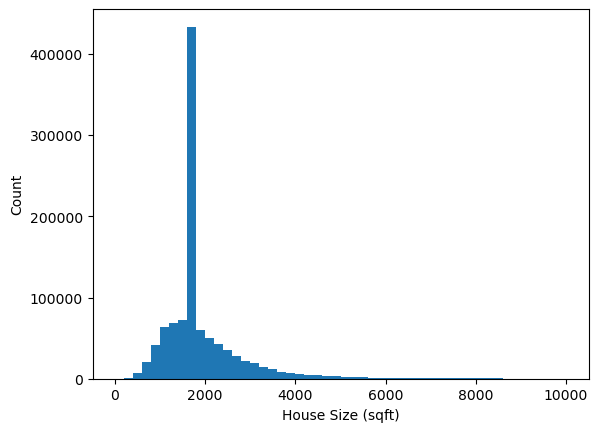

In [62]:
filtered = df[df['house_size'] < 10000]
plt.hist(filtered['house_size'], bins=50)
plt.xlabel("House Size (sqft)")
plt.ylabel("Count")
plt.show()

**Expected Output:** Histogram showing data distributions  
**Data Engineering Insight:** Distribution analysis validates data quality and identifies potential outliers

### 4.2 Boxplot - Prices by City
**Purpose:** Compare price distributions across market segments  
**Concepts:** Market Comparison, Outlier Detection

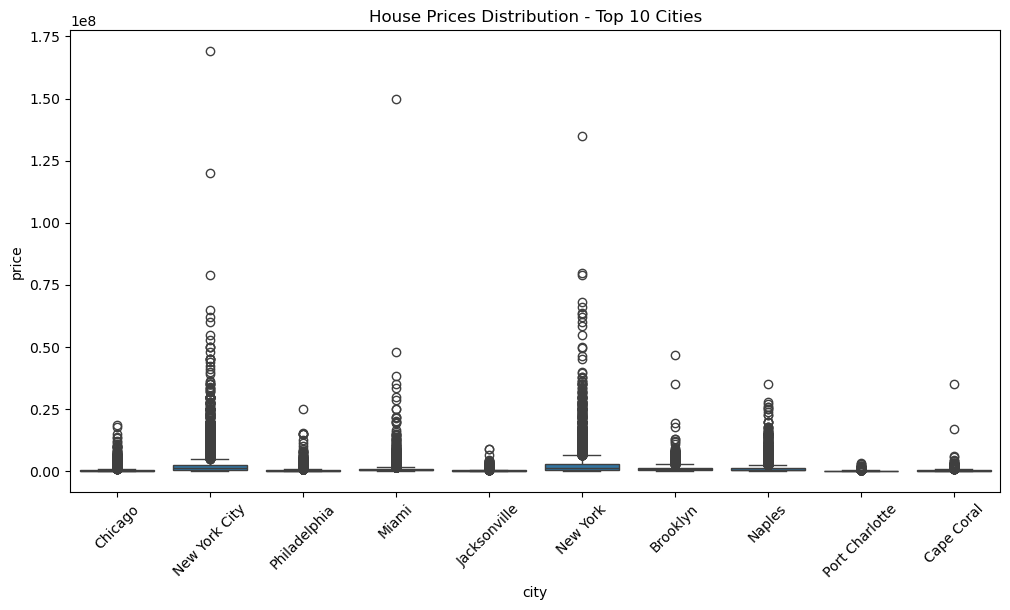

In [65]:
top_cities = df['city'].value_counts().nlargest(10).index

# Filter dataset
df_top = df[df['city'].isin(top_cities)]

# Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(x="city", y="price", data=df_top, order=top_cities)
plt.xticks(rotation=45)
plt.title("House Prices Distribution - Top 10 Cities")
plt.show()

**Expected Output:** Boxplots comparing price distributions across top 10 cities  
**Data Engineering Insight:** Boxplots reveal market variations and pricing anomalies

### 4.3 Pie Chart - Property Types by Bedrooms
**Purpose:** Visualize categorical distributions for market segmentation  
**Concepts:** Market Segmentation, Categorical Analysis


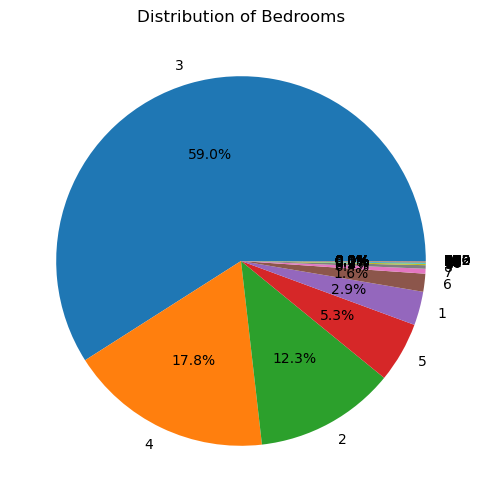

In [68]:
# Ensure 'bed' is integer
df['bed'] = df['bed'].round().astype(int)

# Pie chart
df['bed'].value_counts().plot.pie(
    autopct='%1.1f%%',
    figsize=(6,6),
    ylabel="" 
)
plt.title("Distribution of Bedrooms")
plt.show()


**Expected Output:** Pie chart showing market segmentation  
**Data Engineering Insight:** Categorical visualization reveals market composition and opportunities

### 4.4 Line Plot - Housing Price Trends Over Time
**Purpose:** Analyze temporal trends for market intelligence  
**Concepts:** Time Series Analysis, Trend Detection

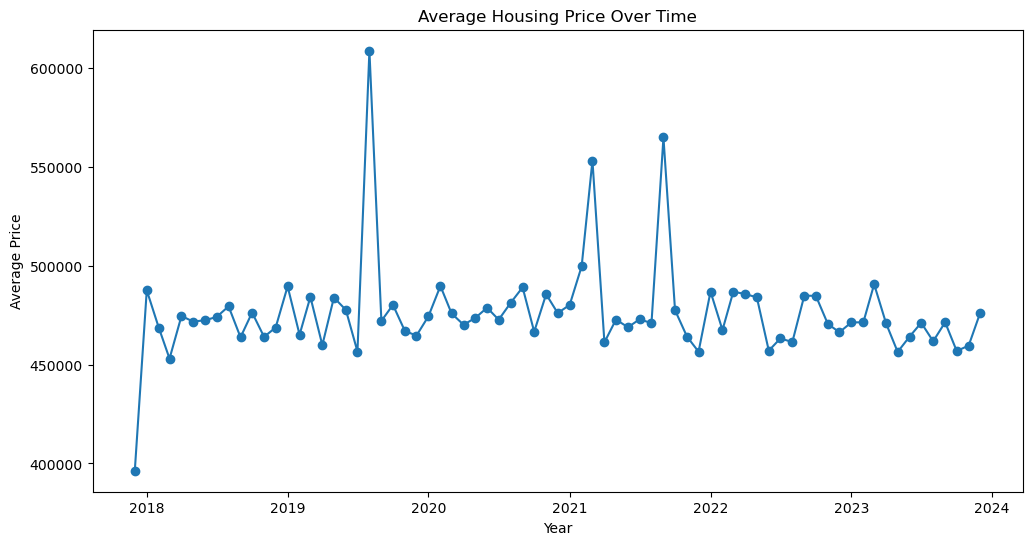

In [71]:
# Group by year and month to get average price
monthly_prices = (
    df.groupby(['listing_year', 'listing_month'])['price']
      .mean()
      .reset_index()
      .rename(columns={'listing_year':'year', 'listing_month':'month'})
)

# Convert to datetime (use day=1 for consistency)
monthly_prices['date'] = pd.to_datetime(
    monthly_prices[['year','month']].assign(day=1)
)

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_prices['date'], monthly_prices['price'], marker='o')
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Average Housing Price Over Time")
plt.show()


**Expected Output:** Time series plots showing market trends by year  
**Data Engineering Insight:** Temporal analysis reveals market cycles and forecasting opportunities

### 4.5 Heatmap - Correlation Validation
**Purpose:** Final validation through correlation visualization  
**Concepts:** Statistical Validation

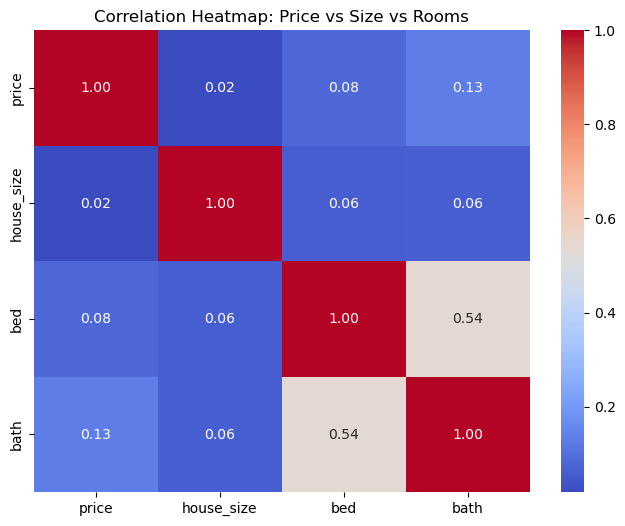

In [74]:
corr_fields = ['price', 'house_size', 'bed', 'bath']

# Compute correlation matrix
corr_matrix = df[corr_fields].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Price vs Size vs Rooms")
plt.show()

**Expected Output:** Heatmap matrix showing correlations between price, house size, and rooms (bed/bath)  
**Data Engineering Insight:** Correlation analysis validates data consistency and highlights logical relationships